# def

In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer

# 加载 .tif 文件并返回 numpy 数组
def load_tif(file_path):
    print(f"Loading TIF file from {file_path}")
    with rasterio.open(file_path) as src:
        image = src.read(1).astype(np.float32)
    return image

# 加载标签矩阵
def load_label_matrix(file_path):
    print(f"Loading label matrix from {file_path}")
    label_matrix = pd.read_csv(file_path, header=None).values
    return label_matrix

# 创建数据集
def create_dataset(base_path):
    indices = ['ExG', 'ExR', 'PRI', 'MGRVI',  'SAVI', 'MSAVI',  'EVI', 'REIP', 'CI', 'OSAVI', 'TVI', 'MCARI', 'TCARI']
    images = []
    masks = []

    print(f"Traversing base directory: {base_path}")
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            if dir_name.startswith('smalldata_'):
                dir_path = os.path.join(root, dir_name)
                print(f"Processing folder: {dir_path}")
                for file_name in os.listdir(dir_path):
                    if file_name.endswith('.tif'):
                        print(f"Processing file: {file_name}")
                        # 创建多通道图像
                        channels = []
                        for index in indices:
                            index_path = os.path.join(dir_path, f"{index}_{file_name.split('_')[1]}_{file_name.split('_')[2].split('.')[0]}.tif")
                            if os.path.exists(index_path):
                                channels.append(load_tif(index_path))
                            else:
                                print(f"File {index_path} does not exist, adding zero array")
                                channels.append(np.zeros((512, 512)))  # 文件不存在时添加零数组
                        
                        # 堆叠通道以创建多通道图像
                        multi_channel_image = np.stack(channels, axis=-1)
                        images.append(multi_channel_image)
                        
                        # 加载对应的标签矩阵
                        label_matrix_file = f"label_matrix_{file_name.split('_')[1]}_{file_name.split('_')[2].split('.')[0]}.csv"
                        label_matrix_path = os.path.join(dir_path, label_matrix_file)
                        if os.path.exists(label_matrix_path):
                            label_matrix = load_label_matrix(label_matrix_path)
                            masks.append(label_matrix)
                        else:
                            print(f"Label matrix {label_matrix_path} does not exist")

    print(f"Finished creating dataset. Number of images: {len(images)}, Number of masks: {len(masks)}")
    return np.array(images), np.array(masks)




#
def calculate_accuracy(y_true, y_pred):
    """
    计算分类准确率
    :param y_true: 实际标签，形状为 (batch_size, height, width)
    :param y_pred: 预测标签，形状为 (batch_size, height, width)
    :param num_classes: 类别数量
    :return: 平均分类准确率
    """
    accuracies = []
    for i in range(y_true.shape[0]):
        true_labels = y_true[i].flatten()
        pred_labels = y_pred[i].flatten()
        
        correct_predictions = np.sum(true_labels == pred_labels)
        total_pixels = true_labels.size
        
        accuracy = correct_predictions / total_pixels
        accuracies.append(accuracy)
    
    return np.mean(accuracies)


class ResizeLayer(Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        return tf.image.resize(inputs, (self.target_height, self.target_width))
    
# 自定义层用于应用 ReLU 激活
class ReluLayer(Layer):
    def call(self, inputs):
        return tf.nn.relu(inputs)
custom_objects = {
    'ResizeLayer': ResizeLayer(512,512),
    'ReluLayer': ReluLayer
}


def calculate_miou(y_true, y_pred, num_classes):
    """
    计算平均交并比 (Mean Intersection over Union, mIoU)
    :param y_true: 实际标签，形状为 (batch_size, height, width)
    :param y_pred: 预测标签，形状为 (batch_size, height, width)
    :param num_classes: 类别数量
    :return: 平均交并比 (mIoU)
    """
    iou_list = []
    for c in range(num_classes):
        true_class = (y_true == c)
        
        pred_class = (y_pred == c)
        
        intersection = np.sum(true_class & pred_class)
        union = np.sum(true_class | pred_class)
        print(c)
        if union == 0:
            iou = 1.0  # If there is no ground truth or predicted instance in this class
        else:
            iou = intersection / union
            print(iou)
        
        iou_list.append(iou)
        miou = np.mean(iou_list)
    return miou


In [2]:
# 使用 custom_object_scope 加载模型
with tf.keras.utils.custom_object_scope(custom_objects):
    model = load_model('inceptionv3_fcn_model.h5',compile=False)

# # 拆分训练和验证数据集
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# preprocess

In [3]:
# 加载数据集
base_path = './testset'
# X, y = create_dataset(base_path)

# # 打印数据形状以进行调试
# print(f'Number of images: {X.shape[0]}, Number of masks: {y.shape[0]}')

# # 确保数据集不为空
# if X.size == 0 or y.size == 0:
#     raise ValueError("The dataset is empty. Please check the data directory and file paths.")

# # 归一化输入图像
# print("Normalizing input images")
# X = X / np.max(X)



In [71]:
X_val, y_val = create_dataset(base_path)


Traversing base directory: ./testset
Processing folder: ./testset/smalldata_3_2
Processing file: NIR_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/ExG_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/ExR_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/PRI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/MGRVI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/SAVI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/MSAVI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/EVI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/REIP_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/CI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/OSAVI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/TVI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/MCARI_3_2.tif
Loading TIF file from ./testset/smalldata_3_2/TCARI_3_2.tif
Loading label matrix from ./testset/smalldata_3_2/label_matrix_3_2.csv
Processing file: REIP_3_2.tif
Loading TIF file from ./t

In [72]:
X_val = X_val / np.max(X_val)

In [73]:
X_val.shape

(63, 512, 512, 13)

In [74]:
y_val.shape

(63, 512, 512)

In [75]:
num_classes=4
y_val = to_categorical(y_val, num_classes=num_classes)

In [28]:
y_val.shape

(63, 512, 512, 4)

In [58]:


# 使用模型预测
y_pred = model.predict(X_val)



2/2 ━━━━━━━━━━━━━━━━━━━━ 142s 68s/step


In [60]:
y_pred.shape

(63, 512, 512, 4)

In [69]:
all_nan = np.all(np.isnan(y_pred))

In [65]:
all_nan

True

# calculate

In [66]:
num_classes=4

In [84]:
y_true_class = np.argmax(y_val, axis=-1)
y_pred_class = np.argmax(y_pred, axis=-1)

In [86]:
y_pred_class

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [80]:
def calculate_miou(y_true, y_pred, num_classes):
    """
    计算平均交并比 (Mean Intersection over Union, mIoU)
    :param y_true: 实际标签，形状为 (batch_size, height, width)
    :param y_pred: 预测标签，形状为 (batch_size, height, width)
    :param num_classes: 类别数量
    :return: 平均交并比 (mIoU)
    """
    iou_list = []
    for c in range(num_classes):
        true_class = (y_true == c)
        
        pred_class = (y_pred == c)
        
        intersection = np.sum(true_class & pred_class)
        union = np.sum(true_class | pred_class)
        # print(c)
        if union == 0:
            iou = 1.0  # If there is no ground truth or predicted instance in this class
            print(union)
        else:
            iou = intersection / union
            # print(iou)
        
        print(iou_list)
        iou_list.append(iou)
        miou = np.mean(iou_list)
    return miou

In [82]:
range(num_classes)

range(0, 4)

In [83]:

iou_list = []

for c in range(num_classes):
    print(c)
    true_class = (y_val == c)
    print(sum(true_class))
    pred_class = (y_pred == c)
    print(sum(true_class))
        
    intersection = np.sum(true_class & pred_class)
    union = np.sum(true_class | pred_class)
    # print(c)
    if union == 0:
        iou = 1.0  # If there is no ground truth or predicted instance in this class
        #print(union)
    else:
        iou = intersection / union
        # print(iou)
        
    #print(iou_list)
    iou_list.append(iou)
    miou = np.mean(iou_list)

print(miou)

0
1
2
3
0.5


In [85]:
calculate_miou(y_true_class, y_pred_class, num_classes)

[]
[0.5344429016113281]
[0.5344429016113281, 0.0]
[0.5344429016113281, 0.0, 0.0]


0.13361072540283203

In [30]:
import numpy as np

def calculate_accuracy(y_true, y_pred, num_classes):
    """
    计算分类准确率
    :param y_true: 实际标签，形状为 (batch_size, height, width, num_classes)
    :param y_pred: 预测标签，形状为 (batch_size, height, width, num_classes)
    :param num_classes: 类别数量
    :return: 分类准确率
    """
    # Convert one-hot encoded labels to class indices
    y_true_class = np.argmax(y_true, axis=-1)
    y_pred_class = np.argmax(y_pred, axis=-1)
    
    # Calculate accuracy
    correct_predictions = np.sum(y_true_class == y_pred_class)
    total_predictions = y_true_class.size
    
    accuracy = correct_predictions / total_predictions
    return accuracy


In [31]:

calculate_accuracy(y_val, y_pred,num_classes=4)


0.5344429016113281

In [32]:
def calculate_accuracy2(y_true, y_pred):
    """
    计算分类准确率
    :param y_true: 实际标签，形状为 (batch_size, height, width)
    :param y_pred: 预测标签，形状为 (batch_size, height, width)
    :param num_classes: 类别数量
    :return: 平均分类准确率
    """
    # y_true_class = np.argmax(y_true, axis=-1)
    # y_pred_class = np.argmax(y_pred, axis=-1)
    accuracies = []
    for i in range(y_true.shape[0]):
        true_labels = y_true[i].flatten()
        pred_labels = y_pred[i].flatten()
        
        correct_predictions = np.sum(true_labels == pred_labels)
        total_pixels = true_labels.size
        
        accuracy = correct_predictions / total_pixels
        accuracies.append(accuracy)
    
    return np.mean(accuracies)

In [33]:
y_true_class = np.argmax(y_val, axis=-1)
y_pred_class = np.argmax(y_pred, axis=-1)

In [34]:
calculate_accuracy2(y_true_class, y_pred_class)

0.5344429016113281

# Visualization

In [35]:
y_true_class.shape

(63, 512, 512)

In [57]:
y_pred

array([[[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        ...,

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         

In [52]:
all_zeros = np.all(y_pred == 0)
all_zeros

False

In [42]:
import numpy as np

# 假设 y_val 是你的原始数组
# 下面是一个示例数组的生成
y_val = np.random.rand(63, 512, 512)

# 从第一个维度下每21个取一个
plt_pred = y_pred_class[::21]
plt_true = y_true_class[::21]

In [44]:
plt_pred.shape

(3, 512, 512)

In [46]:
first_image_matrix = plt_pred[0]

In [47]:
print(first_image_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


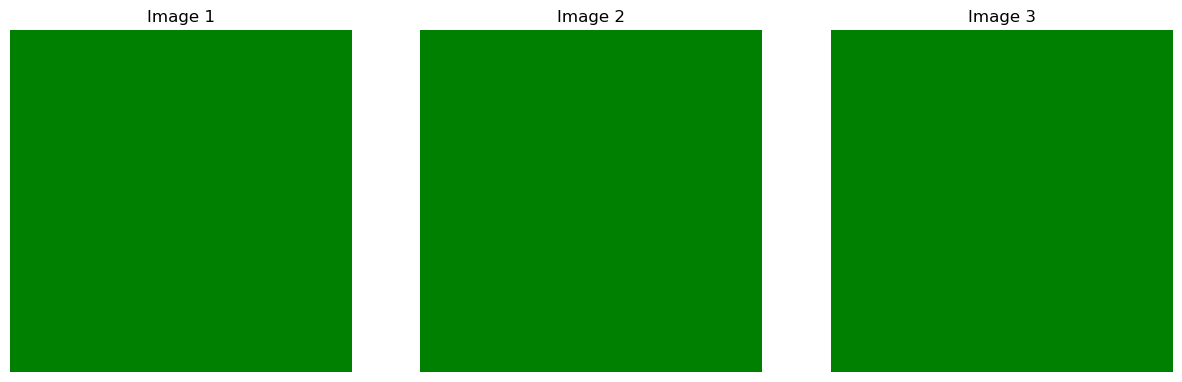

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap([colors[key] for key in range(4)])

# 绘制三张图片
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(plt_pred[i], cmap=cmap, vmin=0, vmax=3)
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

red_path = "Red.tif"  # 红色地址
nir_path = "NIR.tif"  # 红外地址

# 打开红色通道TIF文件
with rasterio.open(red_path) as red_ds:
    red_array = red_ds.read(1).astype(np.float32)
    profile = red_ds.profile

# 打开红外TIF文件
with rasterio.open(nir_path) as nir_ds:
    nir_array = nir_ds.read(1).astype(np.float32)

# 计算NDVI
ndvi = (nir_array - red_array) / (nir_array + red_array + 1e-8)

# 分类映射：这里您需要定义3类的条件
ndvi_mapped = np.where(ndvi > 0.54, 0, 
               np.where(ndvi >= 0.41, 1, 
               np.where(ndvi < 0.41, 2, 3)))  # 假设NDVI小于0.41分类为3



# 将NDVI映射矩阵转换为DataFrame
df = pd.DataFrame(ndvi_mapped)

# 定义保存路径
csv_path = "label_matrix.csv"

# 保存为CSV文件
df.to_csv(csv_path, index=False, header=False)

# 定义颜色映射，添加黄色为新的分类3
colors = {0: 'green', 1: 'red', 2: 'white', 3: 'yellow'}

# 创建彩色图像
ndvi_color_mapped = np.zeros((ndvi_mapped.shape[0], ndvi_mapped.shape[1], 3), dtype=np.uint8)

# 对每个值着色
for i, color in colors.items():
    # 获取颜色的RGB值
    color_rgb = np.array(plt.cm.colors.to_rgba(color)[:3]) * 255
    # 根据颜色和值进行索引和赋值
    ndvi_color_mapped[ndvi_mapped == i] = color_rgb

ndvi_color_path = "label_matrix_image.png"

# 显示彩色图像
plt.imshow(ndvi_color_mapped)
plt.axis('off')

# 保存图像到文件
plt.savefig(ndvi_color_path, bbox_inches='tight', pad_inches=0, dpi=96)

# 关闭图形窗口
plt.close()









